# CASO REAL

In [1]:
import pandas as pd
import time
timestr = time.strftime("%Y%m%d-%H%M%S")
filename = "data_anonymized"
file = "data/"+  filename + ".csv"
df = pd.read_csv(file,index_col=0, parse_dates=['Fecha'])

# Limpiamos los datos y realizamos comprobaciones
df.head()

,PesoNeto,PesoProm,risk_daysThIn,risk_daysThOut,sab_hol1,sab_y_otros_hol1,sab_hol2,sab_y_otros_hol2,lun_hol1,lun_y_otros_hol1,...,prec-1,prec-2,pepiPeso-1,pepiPeso-2,pepiPeso-3,pepiPeso-4,pepiPeso-5,week,year,month
Fecha,,,,,,,,,,,,,,,,,,,,,
2014-09-07,17.940056,825.549472,0.020309,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.121857,6.817221,0.030464
2014-09-14,151.058656,1107.365185,0.016925,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.002713,NaN,136.026243,NaN,NaN,NaN,NaN,0.125242,6.817221,0.030464
2014-09-21,466.289133,1759.997341,0.003385,0.003385,0.0,0.0,0.0,0.0,0.0,0.0,...,0.001564,0.002713,615.008812,136.026243,NaN,NaN,NaN,0.128627,6.817221,0.030464
2014-09-28,1216.741983,2372.115435,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.001629,0.001564,1390.625129,615.008812,136.026243,NaN,NaN,0.132012,6.817221,0.030464
2014-10-05,1694.086253,2984.975953,0.013540,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.001616,0.001629,2396.408978,1390.625129,615.008812,136.026243,NaN,0.135397,6.817221,0.033849


# Agrupar y crear la time series
Agrupamos semanalmente y construimos una serie

In [2]:
# Convertir el dataframe en una serie temporal
ts = pd.Series(df["PesoNeto"].values, index=df.index)
ts.head()

Fecha
2014-09-07      17.940056
2014-09-14     151.058656
2014-09-21     466.289133
2014-09-28    1216.741983
2014-10-05    1694.086253
dtype: float64

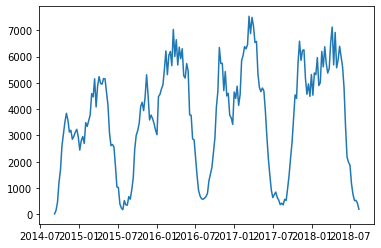

In [4]:
# Representar la serie temporal
import matplotlib.pyplot as plt
plt.plot(ts)

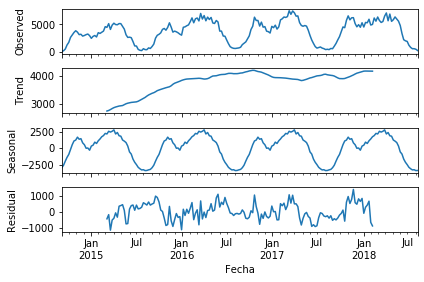

In [7]:
# Descomposicion de la serie
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib import pyplot
series = ts
result = seasonal_decompose(series, model='additive', freq=52)
f = result.plot()
pyplot.show()
# Guardamos a fichero la imagen
# f.savefig("results/ARIMA/" + "_file:" + filename + "_" + timestr + "_Decomposition.pdf")


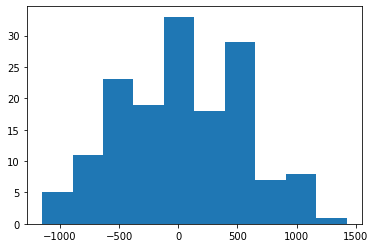

In [9]:
# Vemos los histogramas de la serie descompuesta
#dummy = plt.hist(result.resid, bins=20)
dummy = plt.hist(result.resid[result.resid>-10**20], bins=10)

## Dividir entre Train y Test.
Train a su vez se dividiran en subtrain y subvalidation ya que utilizamos Cross Validation
Test nos servirá para hacer una simulación final de que estamos haciendo bien las predicciones
La métrica que se minimiza del error es la correspondiente a Cross Validation. Posteriormente podemos compararla con la métrica del Test, deberían ser parecidas

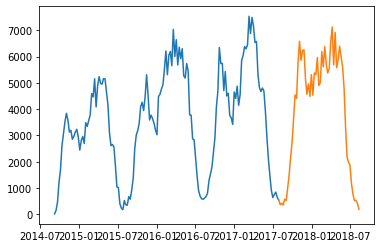

In [15]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy
X_train, X_test, Y_train, Y_test = train_test_split(ts, ts, test_size=0.26, shuffle=False)

# De momento trabajamos sin variables regresoras así que vamos a trabajar unicamente con y_train y y_test
plt.plot(Y_train)
plt.plot(Y_train[-1::].append(Y_test))
plt.show()

## Entrenar el modelo con los parametros obtenidos en CV
Se entrena el modelo con los parametors optimizados de CV y se hacen predicciones

In [26]:
from sklearn.model_selection import TimeSeriesSplit
import statsmodels.api as sm

# Introducir aqui los parametros ya tuneados
order = (1, 0, 1)
seasonal_order = (0, 1, 0, 53)
enforce_stationarity = True
enforce_invertibility = True

# Prediccion a h semanas
h = 3

# Ventana movil de train
Rollingts = Y_train


yhat = []
yhatvalue = []

# Bucle de test con rolling window
for index in range(len(Y_test[0::])+1 - h):
    print(len(Y_test[0::])+1-h - index)
    modelo_test = sm.tsa.statespace.SARIMAX(Rollingts, order = order, seasonal_order = seasonal_order,
                                            trend='t', enforce_stationarity=enforce_stationarity,
                                            enforce_invertibility=enforce_invertibility)       
    model_fit = modelo_test.fit()
    valforecast = model_fit.forecast(h)
    print(valforecast)

    # Guardamos los datos de prediccion
    if len(yhat) == 0:
        yhat = valforecast[-1::]
    else:
        yhat = yhat.append(valforecast[-1::])

    Rollingts = Rollingts.append(Y_test[index:index+1])


#plt.plot(Y_test[h-1:len(yhat)])
#plt.plot(yhat)
#plt.show()


52


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  % freq, ValueWarning)


2017-08-06    475.886042
2017-08-13    512.292362
2017-08-20    608.960367
Freq: W-SUN, dtype: float64
51


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  % freq, ValueWarning)


2017-08-13    436.749667
2017-08-20    538.865933
2017-08-27    650.567969
Freq: W-SUN, dtype: float64
50


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  % freq, ValueWarning)


2017-08-20    531.918585
2017-08-27    644.144663
2017-09-03    816.910940
Freq: W-SUN, dtype: float64
49


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  % freq, ValueWarning)


2017-08-27     524.352452
2017-09-03     706.222654
2017-09-10    1238.063818
Freq: W-SUN, dtype: float64
48


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  % freq, ValueWarning)


2017-09-03     740.291177
2017-09-10    1269.503536
2017-09-17    1562.889008
Freq: W-SUN, dtype: float64
47


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  % freq, ValueWarning)


2017-09-10    1121.617319
2017-09-17    1426.218180
2017-09-24    1734.971458
Freq: W-SUN, dtype: float64
46


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  % freq, ValueWarning)


2017-09-17    1336.046908
2017-09-24    1651.629550
2017-10-01    2250.318585
Freq: W-SUN, dtype: float64
45


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  % freq, ValueWarning)


2017-09-24    1767.486344
2017-10-01    2357.321904
2017-10-08    2957.735971
Freq: W-SUN, dtype: float64
44


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  % freq, ValueWarning)


2017-10-01    2630.134933
2017-10-08    3208.907037
2017-10-15    4402.767589
Freq: W-SUN, dtype: float64
43


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  % freq, ValueWarning)


2017-10-08    3299.913599
2017-10-15    4486.259297
2017-10-22    5094.512624
Freq: W-SUN, dtype: float64
42


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  % freq, ValueWarning)


2017-10-15    4713.145161
2017-10-22    5302.096357
2017-10-29    6960.588768
Freq: W-SUN, dtype: float64
41


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  % freq, ValueWarning)


2017-10-22    5184.078554
2017-10-29    6852.680992
2017-11-05    6243.985625
Freq: W-SUN, dtype: float64
40


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  % freq, ValueWarning)


2017-10-29    6312.377424
2017-11-05    5750.164869
2017-11-12    5796.024797
Freq: W-SUN, dtype: float64
39


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  % freq, ValueWarning)


2017-11-05    5359.711861
2017-11-12    5440.283515
2017-11-19    4475.563948
Freq: W-SUN, dtype: float64
38


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  % freq, ValueWarning)


2017-11-12    6289.938762
2017-11-19    5250.826882
2017-11-26    5968.162550
Freq: W-SUN, dtype: float64
37


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  % freq, ValueWarning)


2017-11-19    4952.691761
2017-11-26    5695.628691
2017-12-03    4787.487351
Freq: W-SUN, dtype: float64
36


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  % freq, ValueWarning)


2017-11-26    6555.790089
2017-12-03    5573.577095
2017-12-10    5623.696291
Freq: W-SUN, dtype: float64
35


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  % freq, ValueWarning)


2017-12-03    5373.390302
2017-12-10    5441.411475
2017-12-17    4571.705195
Freq: W-SUN, dtype: float64
34


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  % freq, ValueWarning)


2017-12-10    5306.204799
2017-12-17    4447.997102
2017-12-24    4348.840621
Freq: W-SUN, dtype: float64
33


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  % freq, ValueWarning)


2017-12-17    3954.096041
2017-12-24    3898.119191
2017-12-31    3670.177664
Freq: W-SUN, dtype: float64
32


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  % freq, ValueWarning)


2017-12-24    4555.167615
2017-12-31    4270.524199
2018-01-07    5475.512448
Freq: W-SUN, dtype: float64
31


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  % freq, ValueWarning)


2017-12-31    4225.643905
2018-01-07    5434.519226
2018-01-14    5171.259719
Freq: W-SUN, dtype: float64
30


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  % freq, ValueWarning)


2018-01-07    6143.886749
2018-01-14    5821.946928
2018-01-21    6215.800383
Freq: W-SUN, dtype: float64
29


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  % freq, ValueWarning)


2018-01-14    4825.183409
2018-01-21    5301.671988
2018-01-28    4584.530034
Freq: W-SUN, dtype: float64
28


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  % freq, ValueWarning)


2018-01-21    5637.370289
2018-01-28    4893.848295
2018-02-04    5292.952094
Freq: W-SUN, dtype: float64
27


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  % freq, ValueWarning)


2018-01-28    4700.111049
2018-02-04    5114.083624
2018-02-11    6401.162457
Freq: W-SUN, dtype: float64
26


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  % freq, ValueWarning)


2018-02-04    5857.675712
2018-02-11    7089.256154
2018-02-18    7242.107532
Freq: W-SUN, dtype: float64
25


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  % freq, ValueWarning)


2018-02-11    6538.262423
2018-02-18    6732.491573
2018-02-25    7062.085574
Freq: W-SUN, dtype: float64
24


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  % freq, ValueWarning)


2018-02-18    5827.912974
2018-02-25    6229.383849
2018-03-04    6204.173459
Freq: W-SUN, dtype: float64
23


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  % freq, ValueWarning)


2018-02-25    6446.360539
2018-03-04    6402.494906
2018-03-11    6601.436121
Freq: W-SUN, dtype: float64
22


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  % freq, ValueWarning)


2018-03-04    5917.526644
2018-03-11    6152.166013
2018-03-18    7295.573253
Freq: W-SUN, dtype: float64
21


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  % freq, ValueWarning)


2018-03-11    6416.273598
2018-03-18    7540.021930
2018-03-25    6923.513947
Freq: W-SUN, dtype: float64
20


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  % freq, ValueWarning)


2018-03-18    7149.956682
2018-03-25    6559.508119
2018-04-01    7237.687778
Freq: W-SUN, dtype: float64
19


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  % freq, ValueWarning)


2018-03-25    5515.310856
2018-04-01    6258.308254
2018-04-08    6040.111034
Freq: W-SUN, dtype: float64
18


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  % freq, ValueWarning)


2018-04-01    6275.935204
2018-04-08    6056.583388
2018-04-15    5540.430055
Freq: W-SUN, dtype: float64
17


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  % freq, ValueWarning)


2018-04-08    6215.100125
2018-04-15    5691.553239
2018-04-22    5822.018678
Freq: W-SUN, dtype: float64
16


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  % freq, ValueWarning)


2018-04-15    6246.968531
2018-04-22    6346.555691
2018-04-29    5162.431281
Freq: W-SUN, dtype: float64
15


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  % freq, ValueWarning)


2018-04-22    6010.565734
2018-04-29    4846.464008
2018-05-06    4392.872196
Freq: W-SUN, dtype: float64
14


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  % freq, ValueWarning)


2018-04-29    5376.523336
2018-05-06    4886.316610
2018-05-13    4764.219637
Freq: W-SUN, dtype: float64
13


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  % freq, ValueWarning)


2018-05-06    5002.428582
2018-05-13    4871.496868
2018-05-20    5022.453927
Freq: W-SUN, dtype: float64
12


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  % freq, ValueWarning)


2018-05-13    5385.086871
2018-05-20    5493.321500
2018-05-27    5358.158480
Freq: W-SUN, dtype: float64
11


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  % freq, ValueWarning)


2018-05-20    6100.608346
2018-05-27    5910.317443
2018-06-03    5083.768657
Freq: W-SUN, dtype: float64
10


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  % freq, ValueWarning)


2018-05-27    5851.715535
2018-06-03    5030.505393
2018-06-10    4011.753376
Freq: W-SUN, dtype: float64
9


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  % freq, ValueWarning)


2018-06-03    4884.223529
2018-06-10    3878.093932
2018-06-17    3000.386642
Freq: W-SUN, dtype: float64
8


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  % freq, ValueWarning)


2018-06-10    3832.522596
2018-06-17    2958.796240
2018-06-24    2292.857697
Freq: W-SUN, dtype: float64
7


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  % freq, ValueWarning)


2018-06-17    2658.394831
2018-06-24    2019.585993
2018-07-01    1441.315933
Freq: W-SUN, dtype: float64
6


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  % freq, ValueWarning)


2018-06-24    1733.726931
2018-07-01    1182.327590
2018-07-08     915.186221
Freq: W-SUN, dtype: float64
5


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  % freq, ValueWarning)


2018-07-01    1331.605694
2018-07-08    1050.352705
2018-07-15    1170.866278
Freq: W-SUN, dtype: float64
4


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  % freq, ValueWarning)


2018-07-08    1374.259599
2018-07-15    1464.237225
2018-07-22    1539.197936
Freq: W-SUN, dtype: float64
3


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  % freq, ValueWarning)


2018-07-15    1341.474109
2018-07-22    1428.076310
2018-07-29    1216.201956
Freq: W-SUN, dtype: float64
2


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  % freq, ValueWarning)


2018-07-22    1083.035578
2018-07-29     903.827299
2018-08-05     823.434832
Freq: W-SUN, dtype: float64
1


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  % freq, ValueWarning)


2018-07-29    566.869509
2018-08-05    519.002088
2018-08-12    394.788570
Freq: W-SUN, dtype: float64


In [27]:
# yhat

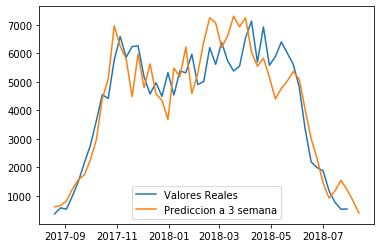

In [28]:
f, ax = plt.subplots()
ax.plot(Y_test[h-1:len(yhat)], label="Valores Reales")
ax.plot(yhat, label="Prediccion a 3 semana")
ax.legend()
plt.show()

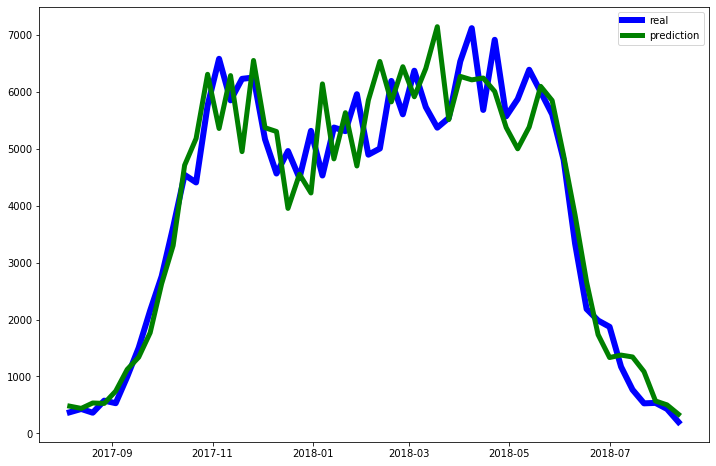

In [23]:
## VARIABLES
# FIGURE TRAIN TEST
ftraintest, axtraintest = plt.subplots(figsize = [12,8]) # no visible frame
df_modelo = Y_test[h-1:]
axtraintest.plot(Y_test[h-1:len(yhat)], 'b', label= "real",lw=6)
axtraintest.plot(yhat,'g',label= "prediction", lw=5)
axtraintest.legend()
ftraintest.savefig("results/ARIMA/h" + str(h)+ "/Hyperparameter_ARIMA_h" + str(h) +
                    "_file:" + filename + "_" + timestr + "_PREDICTIONfig.pdf")

###########################################################
#SAVE SERIES #############################################
###########################################################
df_modelo = pd.merge(pd.DataFrame(Y_test[h-1:]), pd.DataFrame(yhat), left_index=True, right_index=True)
df_modelo.columns = ["real", "forecast"]
df_modelo.to_csv("results/ARIMA/h" + str(h) + "/Hyperparameter_ARIMA_h" + str(h) + "_file:" +
                  filename + "_" +   timestr + "PREDICCION.csv")



In [24]:
umbral = max(df_modelo["real"])/10
import numpy as np
df_modelo_mod = df_modelo[df_modelo["real"] > umbral]
# Error medio quitando un extremo
# Error medio cometido

with open("results/ARIMA/h" + str(h) + "/Hyperparameter_ARIMA_h:" + str(h) + "_file:" +
          filename + "_" + timestr + "ERRORS.csv", 'w') as file:
    print("Error medio cometido (quitando minimos): " + str(round(np.mean(abs(df_modelo_mod["forecast"] - df_modelo_mod["real"])/df_modelo_mod["real"]), 3)), file=file)
    print("Error medio cometido: " + str(round(np.mean(abs(df_modelo["forecast"] - df_modelo["real"])/df_modelo["real"]), 3)), file=file)


In [25]:
print("Error medio cometido (quitando minimos): " + str(round(np.mean(abs(df_modelo_mod["forecast"] - df_modelo_mod["real"])/df_modelo_mod["real"]), 3)))
print("Error medio cometido: " + str(round(np.mean(abs(df_modelo["forecast"] - df_modelo["real"])/df_modelo["real"]), 3)))


Error medio cometido (quitando minimos): 0.144
Error medio cometido: 0.181


(array([3., 3., 3., 0., 2., 3., 3., 3., 3., 6., 2., 4., 3., 3., 1., 0., 0.,
        0., 2., 1.]),
 array([-1280.07293872, -1127.28455468,  -974.49617065,  -821.70778662,
         -668.91940259,  -516.13101855,  -363.34263452,  -210.55425049,
          -57.76586646,    95.02251758,   247.81090161,   400.59928564,
          553.38766967,   706.17605371,   858.96443774,  1011.75282177,
         1164.54120581,  1317.32958984,  1470.11797387,  1622.9063579 ,
         1775.69474194]),
 <a list of 20 Patch objects>)

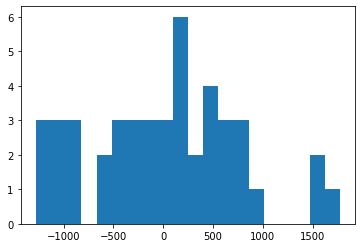

In [31]:
plt.hist(df_modelo_mod["forecast"] - df_modelo_mod["real"], bins=20)